# Object detection #1
sources: https://pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/

Naive computer vision with image classifier deep learning, precursor to specialized algorithms like selective search and object detection models like fast RCNN and faster RCNN.

## Summary
Following are the steps for converting an image classifier into an object detector:
1) input image

2) construct image pyramid

3) sliding window on each scale of image pyramid

4) for each sliding window step, extract ROI

5) pass ROI through CNN for classification

6) min probability test passes, record class and bbox

7) apply class-wise NMS

8) return results

*ROI = region of interest

*non-maxima suppression (NMS) means collapsing weak overlapping bboxes in favour of more confident ones, ultimately forming one bbox per object

## Dependencies

In [1]:
import tensorflow as tf
import numpy as np
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
import matplotlib.pyplot as plt
import time
import cv2

## NMS
non-maxima suppression (NMS) removes redundant bboxes by discarding those that has overlaps above a given threshold

In [2]:
# Felzenszwalb et al.
# boxes should be defined as [(start_x, start_y, end_x, end_y),...]
def NMS(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    # picked indexes
    pick = []
    # coords of all bboxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute area of bboxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    # get indexes sorted by bottom right coord
    idxs = np.argsort(x1)
    # while there are still bboxes not checked
    while len(idxs) > 0:
        # grab the last idx
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i) # list of boxes picked (curr is cfm picked as overlapped bboxes are discarded beforehand)
        suppress = [] # list of boxes to be deleted
        idxs = idxs[:-1]
        # compare all bboxes with last
        for pos in range(0, last):
            j = idxs[pos]
            # compare box i and j for overlap
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]
            # overlap above threshold? Pos to be deleted
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in suppression list
        idxs = np.delete(idxs, suppress)
    # only picked boxes returned
    return boxes[pick]

## Sliding window
Sliding window utility, will be run over each image (scaled as per image pyramid) with specified step. In practice step is usually in the range of 4-8.

In [3]:
# ws: window size, the size of the window we are going to extract from our image
def sliding_window(image, step, ws):
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield since this will be a python generator
            # the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

## Image pyramid
Generate an image pyramid, bottom tier is original size, each subsequent tier is downsized by a scale until minSize is reached.

In [4]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # bottom tier = original image
    yield image
    # downscale until minSize
    while image.shape[0] >= minSize[1] and image.shape[1] >= minSize[0]:
        # compute size of next image in pyramid
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        yield image

## CNN
We will load a CNN model pre-trained with ImageNet weights.

In [5]:
model = ResNet50(weights="imagenet", include_top=True)

## Constants and test data

In [6]:
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = (250, 250) # fixed size regardless of image pyramid dimens
INPUT_SIZE = (224, 224) # for classifier
MIN_CONF = 0.98 # min confidence for classifiying

In [7]:
orig = cv2.imread('hummingbird.png')
orig = np.flip(orig, axis=-1)
resize_ratio = WIDTH / orig.shape[1]
orig = cv2.resize(orig, (int(orig.shape[1] * resize_ratio), int(orig.shape[0] * resize_ratio)), interpolation=cv2.INTER_LINEAR)
(H, W) = orig.shape[:2]

## Run image through pyramid generator

In [8]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

# lists to hold ROIs generated from the image and coords of ROI in original img
rois = []
locs = []

# time keeping
start = time.time()

In [9]:
for image in pyramid:
    # determine scale factor of current pyramid layer
    scale = W / float(image.shape[1])
    w = int(ROI_SIZE[0] * scale)
    h = int(ROI_SIZE[1] * scale)
    print(image.shape)
    # for each layer of the pyramid, do sliding window
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the coords and dimens of ROI to original img
        x = int(x * scale)
        y = int(y * scale)
        # take the ROI and resize + pre-process it, will be fed to classifier
        roi = cv2.resize(roiOrig, INPUT_SIZE, interpolation=cv2.INTER_LINEAR)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)
        # update lists
        rois.append(roi)
        locs.append((x, y, x + w, y + h))

(337, 600, 3)
(224, 400, 3)


In [10]:
end = time.time()
print('Extracting ROIs took {:.5f}s'.format(end - start))

Extracting ROIs took 0.11203s


## Run predictions on ROI
Run the ROIs (resized to original scale) through the classifier.

In [11]:
rois = np.array(rois, dtype=np.float32)
print('Classifying ROIs...')
start = time.time()
model_preds = model.predict(rois)
end = time.time()
print('Classifying ROIs took {:.5f}s'.format(end - start))

Classifying ROIs...
Classifying ROIs took 6.55548s


Decode the preds and init a dict which maps class labels to any ROIs associated with that label

In [12]:
preds = imagenet_utils.decode_predictions(model_preds, top=1)
labels = {}
for (i, p) in enumerate(preds):
    #  pred info for curr ROI
    (imagenetID, label, prob) = p[0]
    # filter out weak detections
    if prob >= MIN_CONF:
        box = locs[i]
        # append pred to label key of labels
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

## Visualize the results

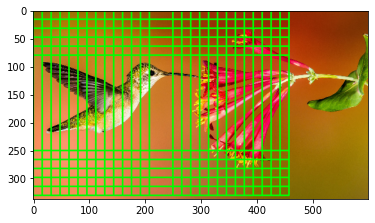

In [13]:
to_track = 'hummingbird'
clone = orig.copy()
for label in labels.keys():
    if label != to_track:
        continue
    # all bboxes over the curr label
    for (box, prob) in labels[label]:
        # draw on img
        (start_x, start_y, end_x, end_y) = box
        cv2.rectangle(clone, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
plt.imshow(clone)

As can be seen above, without NMS we will get a bunch of bboxes centered around the object in focus.

Now with NMS applied.

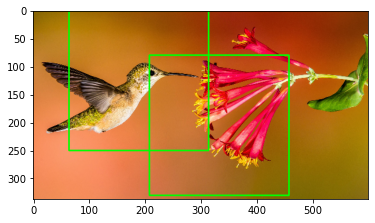

In [14]:
clone = orig.copy()
for label in labels.keys():
    if label != to_track:
        continue
    # run boxes through NMS
    boxes = np.array([x[0] for x in labels[label]])
    boxes = NMS(boxes, 0.3)
    # all bboxes over the curr label
    for box in boxes:
        # draw on img
        (start_x, start_y, end_x, end_y) = box
        cv2.rectangle(clone, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
plt.imshow(clone)

## Drawbacks

Note that we can reduce the amount of bboxes down but this hack-ish solution is still ultimately flawed as we are unable to reduce it to one bbox per object. Not to mention naively sliding through the image and running the classifier per step is computationally expensive. Multiply that with each layer of the image pyramid too.

This approach is also sensitive to parameter choices. Different values in the pyramid scale and window size can lead to dramatically results.